### Keertana V. Chidambaram <br/> Problem Set 8

In [1]:
import graphviz
import numpy as np
import pandas as pd
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz

In [2]:
# IGNORE: this was just to get graphviz to work!
import os
os.environ['PATH'] += os.pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'

#### Problem 1

In [3]:
# Solution 1.a.
data = pd.read_csv('biden.csv')
data = data.dropna()
data.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


In [4]:
xvars = ['female', 'age', 'educ', 'dem', 'rep']
X = data[xvars]
y = data['biden']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=25)

In [5]:
biden_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

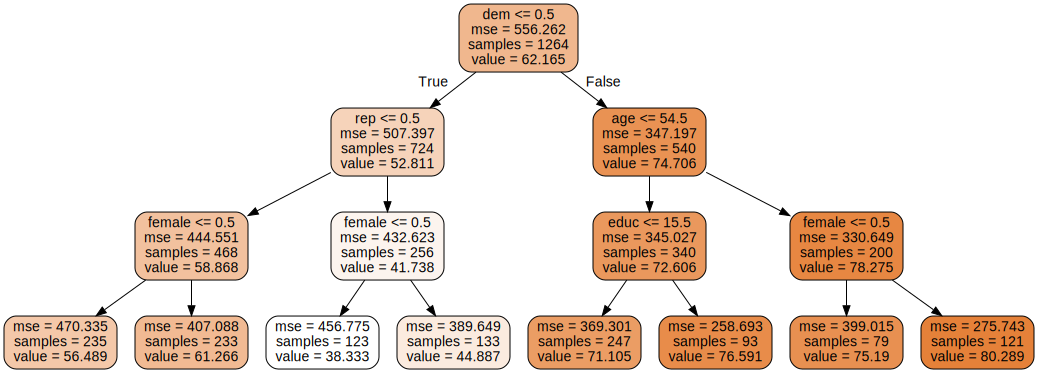

In [6]:
biden_tree_viz = export_graphviz(
    biden_tree,
    out_file=None,
    feature_names=data.columns[1:],
    class_names=data.columns[0],
    rounded=True,
    filled=True,
)

graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz')
graph

The results represent the best binary splits that minimize the error in prediction of 'biden' score given the 5 predictive variables, the max depth and the min samples in a leaf. The root node splits the data based on if the individuals are democrats or not, the left branch gives the non-democrats and the right branch gives the democrats. The non-democrats are further split into republicans and non-republicans and both are again split on the gender (female/not female). While on the 'democrats' branch, the next split is based on age. With age <=54.5, the next split is based on education (<=15.5 or more). And finaly for the older population (age>54.5) the next most relevant split is based on gender. Each of the root nodes give the average value ('value') of the observations corresponding to that leaf's parent nodes. Given a new datapoint, we need to traverse the tree to reach a leaf node and the 'value' for the leaf node would be the predictor from this model for 'biden' score.

In [7]:
y_pred = biden_tree.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1)

MSE= 396.1937146321307


In [8]:
# Solution 1.b.
param_dist1 = {'max_depth': [3, 10],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20)}

biden_tree2 = DecisionTreeRegressor()

random_search1 = RandomizedSearchCV(biden_tree2, 
                                    param_distributions=param_dist1,
                                    n_iter=100, 
                                    n_jobs=-1, 
                                    cv=5, 
                                    random_state=25,
                                    scoring='neg_mean_squared_error')

random_search1.fit(X, y)
print('Best estimator = ', random_search1.best_estimator_)
print('Best tuning parameters = ', random_search1.best_params_)
print('MSE of optimal results =', -random_search1.best_score_)

Best estimator =  DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=17,
           min_samples_split=14, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
Best tuning parameters =  {'max_depth': 3, 'min_samples_leaf': 17, 'min_samples_split': 14}
MSE of optimal results = 401.6903602232667


In [9]:
# Solution 1.c.
param_dist2 = { 'n_estimators': [10, 200],
                'max_depth': [3, 10],
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20),
                'max_features': sp_randint(1, 5)}

biden_tree3 = RandomForestRegressor(bootstrap=True,oob_score=True, random_state=25)

random_search2 = RandomizedSearchCV(biden_tree3, param_distributions=param_dist2, n_iter=100,
                                    n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')

random_search2.fit(X, y)
print('Best estimator = ', random_search2.best_estimator_)
print('Best tuning parameters = ', random_search2.best_params_)
print('MSE of optimal results =', -random_search2.best_score_)

Best estimator =  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=17,
           min_samples_split=13, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=None, oob_score=True, random_state=25,
           verbose=0, warm_start=False)
Best tuning parameters =  {'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 17, 'min_samples_split': 13, 'n_estimators': 10}
MSE of optimal results = 397.0681090117028


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#### Problem 2

In [10]:
data = pd.read_csv('Auto.csv', na_values=['?'])
data = data.dropna()

In [11]:
med = data['mpg'].median()
data['mpg_high'] = (data['mpg'] >= med).astype(int)
data['const'] = 1
data['origin1'] = (data['origin'] == 1).astype(int)
data['origin2'] = (data['origin'] == 2).astype(int)

In [12]:
# Solution 2.a.
xvars = ['const', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin1', 'origin2']
X = data[xvars]
y = data['mpg_high']
Xvals = X.values
yvals = y.values

In [13]:
k = 4
kf = KFold(n_splits=k, shuffle=True, random_state=25)
kf.get_n_splits(Xvals)
MSE_vec = np.zeros(k)
grp0_err_vec = np.zeros(k)
grp1_err_vec = np.zeros(k)

k = 0
for train_index, test_index in kf.split(Xvals):
    print('k =', k)
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    
    LogReg = LogisticRegression(solver='liblinear')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    
    MSE_vec[k] = ((y_test - y_pred) ** 2).mean()
    grp0_err_vec[k] = sum((y_test != y_pred) * (y_test == 0)) / sum(y_test == 0)
    grp1_err_vec[k] = sum((y_test != y_pred) * (y_test == 1)) / sum(y_test == 1)
    
    k += 1

# Note the error rate is calculated as the ratio of mispredicted values to total values for each group
print('Average MSE across k = 4=', round(MSE_vec.mean(), 3))
print('Average error rate for mpg_high == 0 :', round(grp0_err_vec.mean()*100, 3), '%')
print('Average error rate for mpg_high == 1 :', round(grp1_err_vec.mean()*100, 3), '%')

k = 0
k = 1
k = 2
k = 3
Average MSE across k = 4= 0.097
Average error rate for mpg_high == 0 : 11.365 %
Average error rate for mpg_high == 1 : 7.941 %


In [14]:
# Solution 2.b.
xvars = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin1', 'origin2']
X = data[xvars]
y = data['mpg_high']

param_dist3 = { 'n_estimators': [10, 200],
                'max_depth': [3, 8],
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20),
                'max_features': sp_randint(1, 8)}

mpg_tree = RandomForestClassifier(bootstrap=True, oob_score=True, random_state=25)

random_search3 = RandomizedSearchCV(mpg_tree, param_distributions=param_dist3, n_iter=100,
                                    n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')

random_search3.fit(X, y)
print('Best estimator = ', random_search3.best_estimator_)
print('Best tuning parameters = ', random_search3.best_params_)
print('MSE of optimal results =', -random_search3.best_score_)

Best estimator =  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=True, random_state=25, verbose=0, warm_start=False)
Best tuning parameters =  {'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 10}
MSE of optimal results = 0.08928571428571429


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [15]:
# Solution 2.c.
param_dist4 = { 'C': sp_uniform(loc=0.2, scale=4.0),
                'gamma': ['scale', 'auto'],
                'shrinking': [True, False]}

mpg_tree2 = SVC(kernel='rbf')

random_search4 = RandomizedSearchCV(mpg_tree2, param_distributions=param_dist4, n_iter=100,
                                    n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')

random_search4.fit(X, y)
print('Best estimator = ', random_search4.best_estimator_)
print('Best tuning parameters = ', random_search4.best_params_)
print('MSE of optimal results =', -random_search4.best_score_)

Best estimator =  SVC(C=1.8094629152568114, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=False,
  tol=0.001, verbose=False)
Best tuning parameters =  {'C': 1.8094629152568114, 'gamma': 'scale', 'shrinking': False}
MSE of optimal results = 0.11479591836734694


The MSE of each of the models is: logit(0.097), random forest classification (0.089), and support vector classificatin (0.115). Clearly the lowest MSE is for the random forest classification. Thus random forest is the best model for the given data to predict mpg_high.